In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py
from cca.synth_data import gen_gp_kernel, sample_gp, embed_gp, gen_gp_cov
from cca.kron_pca import cv_toeplitz, form_lag_matrix, pv_rearrange, pv_rearrange_inv, toeplitzify
from cca.cov_util import calc_cov_from_cross_cov_mats
from cca.synth_data import gen_chaotic_rnn, gen_lorenz_system

In [2]:
def disp_cov(cov, title=None):
    scale = np.max(np.abs(cov))
    plt.imshow(cov, vmin=-scale, vmax=scale, cmap="RdGy")
    plt.colorbar()
    plt.title(title, fontsize=12)
    plt.show()
    
def regularize_cov(X, T_cov, cov_true):
    
    N = X.shape[1]
    X_with_lags = form_lag_matrix(X, T_cov)
    X_with_lags -= X_with_lags.mean(axis=0)
    cov_sample = np.dot(X_with_lags.T, X_with_lags)/len(X_with_lags)
    
    ll_vals, cov_reg = cv_toeplitz(X_with_lags, N, T_cov, num_folds=10, max_r=2*T_cov-1, small_eigval=1e-2)
    ll_mean = np.mean(ll_vals, axis=0)
    r_vals = np.arange(1, 2*T_cov)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.3)
    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

    ax1.plot(r_vals, ll_vals.T, c="black", linewidth=0.5)
    ax1.plot(r_vals, ll_vals.mean(axis=0), c="black", linewidth=4)
    ax1.set_xlabel("$r$ (num. factors)", fontsize=16)
    ax1.set_ylabel("log likelihood", fontsize=16)
    ax1.set_title("Cross validation", fontsize=16)
    r_opt = np.argmax(ll_vals.mean(axis=0))+1
    ax1.axvline(r_opt, c="red", label="$r_{opt}=$"+str(int(r_opt)))
    ax1.legend(frameon=False, fontsize=16)
    
    R = pv_rearrange(cov_true, N, T_cov)
    U, s, Vt = scipy.linalg.svd(R)
    s = s[:2*T_cov - 1]
    ax2.set_yscale("log")
    ax2.scatter(np.arange(len(s))+1, s, s=30, color="black", zorder=1)
    ax2.axvline(r_opt, c="red", label="$r_{opt}=$"+str(int(r_opt)))
    ax2.set_title("Actual covariance SVs", fontsize=16)
    ax2.set_xlabel("$r$ (num. factors)", fontsize=16)
    ax2.set_ylabel("singular values")
    ax2.legend(frameon=False, fontsize=16)

    scale = np.max(np.abs(np.concatenate((cov_true.flatten(), cov_reg.flatten(), cov_sample.flatten()))))
    ax3.imshow(cov_true, vmin=-scale, vmax=scale, cmap="RdGy")
    ax3.set_title("Actual covariance", fontsize=16)

    ax4.imshow(cov_sample, vmin=-scale, vmax=scale, cmap="RdGy")
    ax4.set_title("Sample covariance", fontsize=16)

    ax5.imshow(cov_reg, vmin=-scale, vmax=scale, cmap="RdGy")
    ax5.set_title("Regularized covariance", fontsize=16)
    
    err_sample = (cov_true - cov_sample).flatten()
    err_reg = (cov_true - cov_reg).flatten()
    scale = np.max(np.abs(np.concatenate((err_sample, err_reg))))
    ax6.set_title("Elementwise errors", fontsize=16)
    ax6.hist(err_sample, range=(-scale, scale), color="black", bins=100, label="sample")
    ax6.hist(err_reg, range=(-scale, scale), color="red", alpha=0.75, bins=100, label="regularized")
    ax6.legend(fontsize=12, frameon=False)
    
    
    
    
    


1


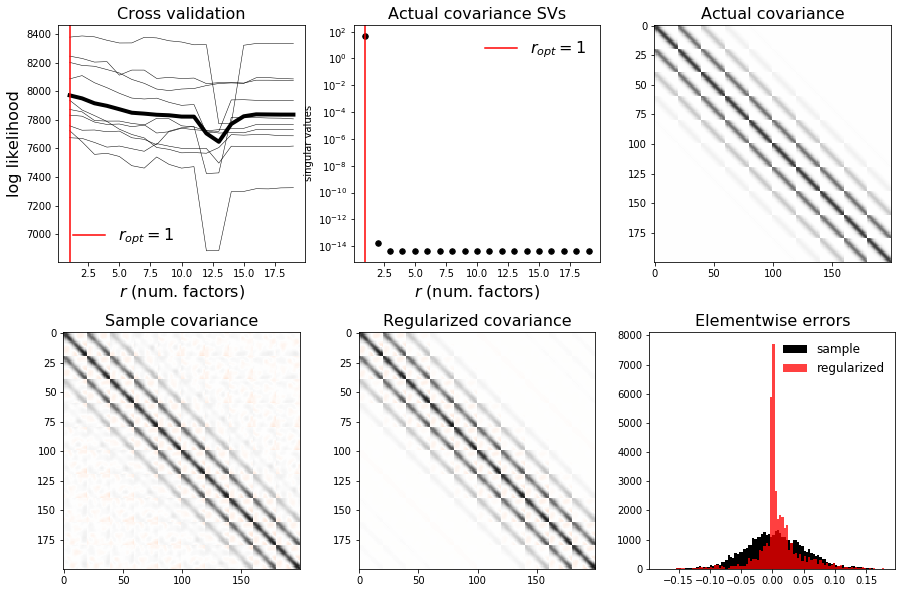

In [3]:
"""
Start out with simple test...
"""

N = 20
T_cov = 10

T_data = 100
num_to_concat = 10

K = gen_gp_kernel("squared_exp", spatial_scale=4, temporal_scale=2)
X = sample_gp(T_data, N, K, num_to_concat=num_to_concat)
cov_true = gen_gp_cov(T_cov, N, K)

regularize_cov(X, T_cov, cov_true)

2


'\nR_true = pv_rearrange(cov_true, N, T_cov)\nU, s, Vt = scipy.linalg.svd(R_true)\nplt.yscale("log")\nplt.scatter(np.arange(len(s))+1, s)\nplt.show()\n'

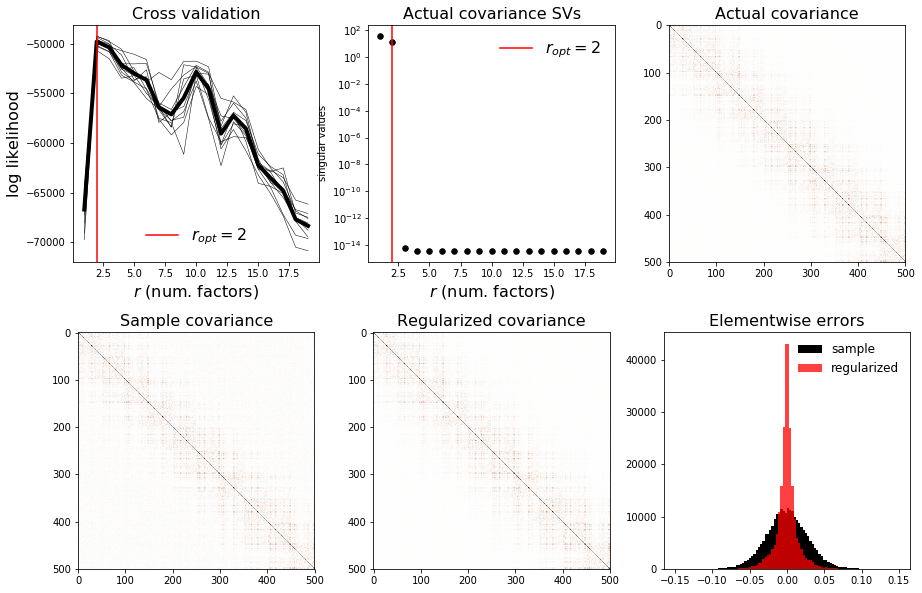

In [4]:
"""
Now sample a low-D GP, embedd it in high-D space, and add structured noise
"""

N = 50
d = 10
T_pi = 5
T_cov = T_pi*2

T_data = 100
num_to_concat = 10

K = gen_gp_kernel("squared_exp", spatial_scale=4, temporal_scale=2)

noise_dim = N/2
noise_variance = 2.5
noise_spectrum = noise_variance*np.exp(-np.arange(N)/(noise_dim/2))
noise_V = scipy.stats.ortho_group.rvs(N)
noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))

X, _, _, _, high_d_cross_cov_mats = embed_gp(T_data, N, d, K, noise_cov, T_pi, num_to_concat=num_to_concat)
cov_true = calc_cov_from_cross_cov_mats(high_d_cross_cov_mats)

regularize_cov(X, T_cov, cov_true)



"""
R_true = pv_rearrange(cov_true, N, T_cov)
U, s, Vt = scipy.linalg.svd(R_true)
plt.yscale("log")
plt.scatter(np.arange(len(s))+1, s)
plt.show()
"""

In [71]:
N_network = 250
data_dt = 0.004
tau = 0.010
gamma = 2.5
T_hours = 0.4/60
T = T_hours*60**2

f = h5py.File("rnn_data.hdf5", "a")
del f["data"]
X = gen_chaotic_rnn(f, N_network, T, data_dt, tau, gamma)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


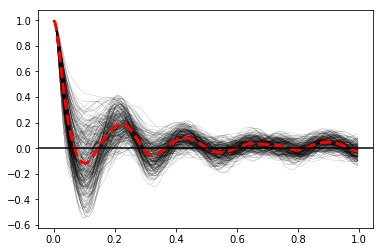

In [72]:
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

#Visualize single-neuron autocorr. functions
max_dt = int(1. / data_dt)
corr_fns = np.zeros((N_network, max_dt))
for dt in range(max_dt):
    print(dt)
    corr_fns[:, dt] = (X[dt:] * X[:len(X)-dt]).sum(axis=0)/(len(X)-dt)
    
t = np.arange(max_dt)*data_dt
plt.plot(t, corr_fns.T, linewidth=0.1, c="black")
plt.plot(t, corr_fns.mean(axis=0), linewidth=3, c="red", linestyle="--")
plt.axhline(0, c="black")

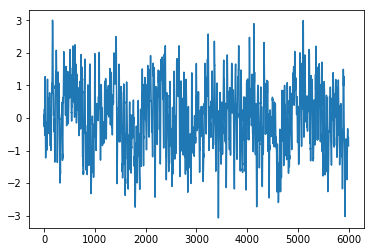

In [73]:
plt.plot(X[:, 4])